## Assignment 1b: Time Series Forecasting

### \yuqing chen \a1841612

#### Follow detail instructions in the assignment specification and use these heading for implementation and discussion

### 1. Read the dataset

In [40]:
import pandas as pd
import numpy as np

# load the data from the dataset
# only keep the date and the Appliances column
df = pd.read_csv('energydata_complete.csv', usecols=['date', 'Appliances'])
print(df.head())

               date  Appliances
0  11/01/2016 17:00          60
1  11/01/2016 17:10          60
2  11/01/2016 17:20          50
3  11/01/2016 17:30          50
4  11/01/2016 17:40          60


In [41]:
df.dtypes

date          object
Appliances     int64
dtype: object

In [42]:
# Preprocessing of data - Check if there is a missing value
print('Number of missing values:', df.isnull().sum())

Number of missing values: date          0
Appliances    0
dtype: int64


As we can see the result, there is no value missing in the dataset. So we don't need to do anything with it

In [43]:
df['date'] = pd.to_datetime(df['date'],format='%d/%m/%Y %H:%M')
df.set_index('date', inplace=True)

In [5]:
print(df.head())

                     Appliances
date                           
2016-01-11 17:00:00          60
2016-01-11 17:10:00          60
2016-01-11 17:20:00          50
2016-01-11 17:30:00          50
2016-01-11 17:40:00          60


In [174]:
print(df.tail())

                     Appliances
date                           
2016-05-27 17:20:00         100
2016-05-27 17:30:00          90
2016-05-27 17:40:00         270
2016-05-27 17:50:00         420
2016-05-27 18:00:00         430


In [175]:
df.dtypes

Appliances    int64
dtype: object

### 2. Analyse and visualise the data

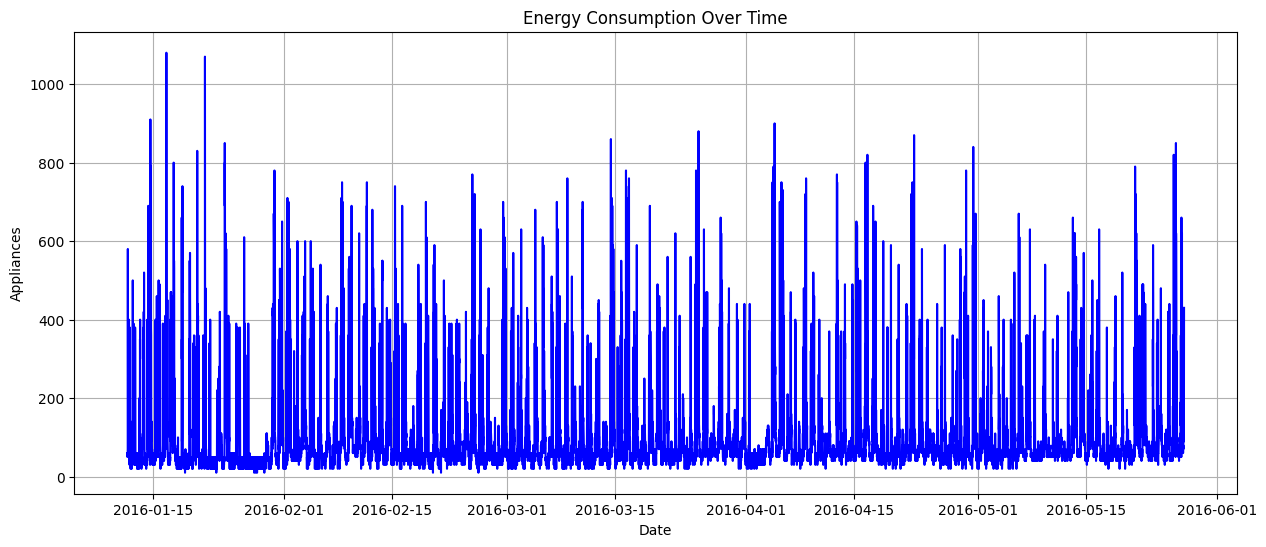

In [44]:
# visualise the data
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Appliances'], color='blue')
plt.title('Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Appliances')
plt.grid(True)
plt.show()

Because the data was recorded at ten-minute intervals, I resampled the time granules so that I could clearly see the long-term trend of the data. 

In [7]:
def SampledDataset(sample_type):
    
    if sample_type =='Hourly':
        df_sampled= df.resample('h').mean()

    elif sample_type =='Weekly':
        df_sampled= df.resample('W').mean()
        
    elif sample_type =='Daily':
        df_sampled= df.resample('D').mean()

    df_sampled.plot(kind='line',figsize=(15, 5),legend=False)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(sample_type,fontsize=10,fontweight='bold')
    plt.xlabel('Date', fontsize=10,fontweight='bold') 
    plt.ylabel('Power[MW]', fontsize=10,fontweight='bold') 
    plt.show()
    return df_sampled

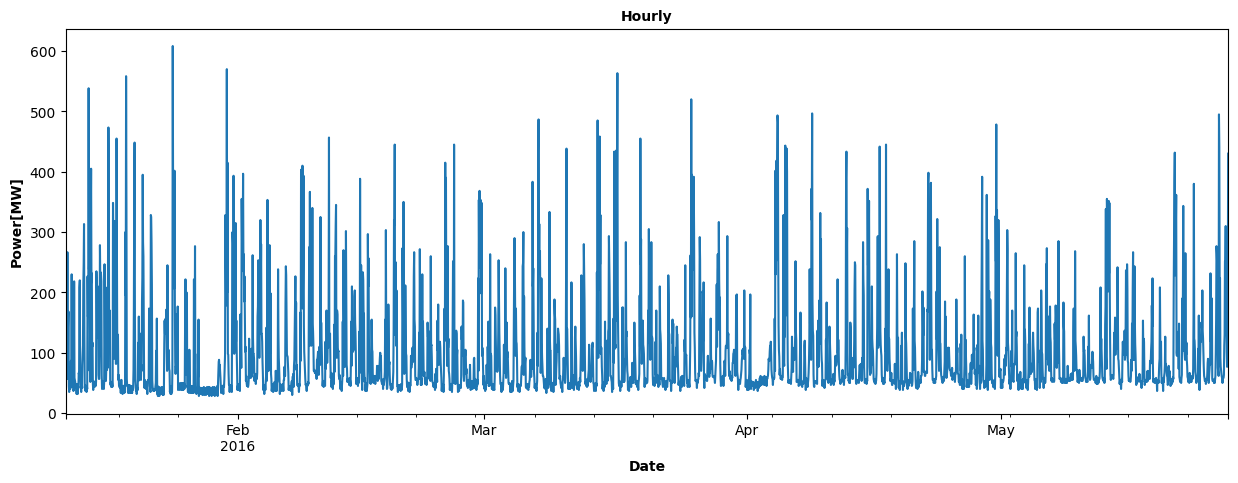

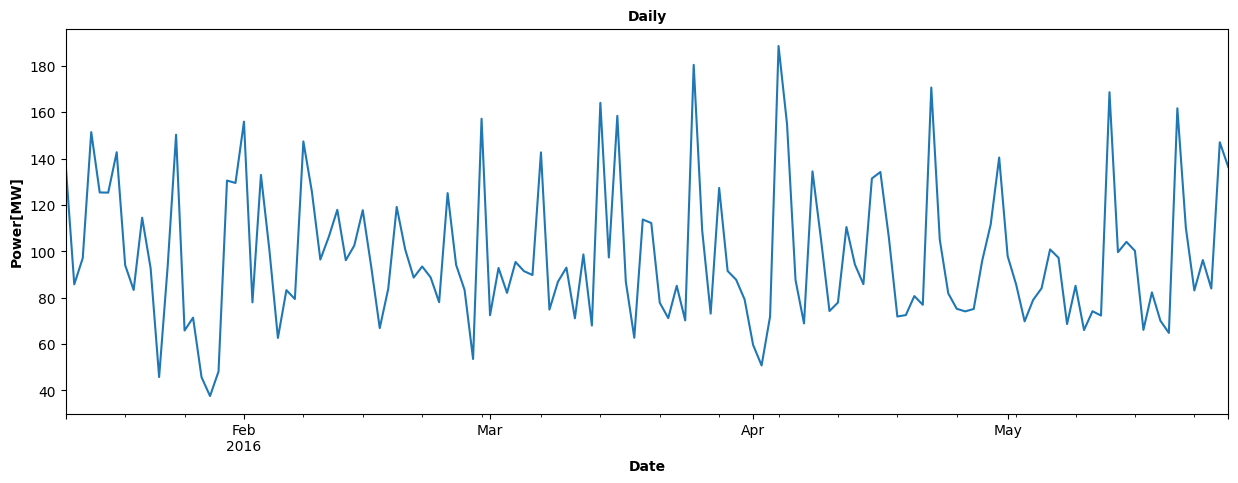

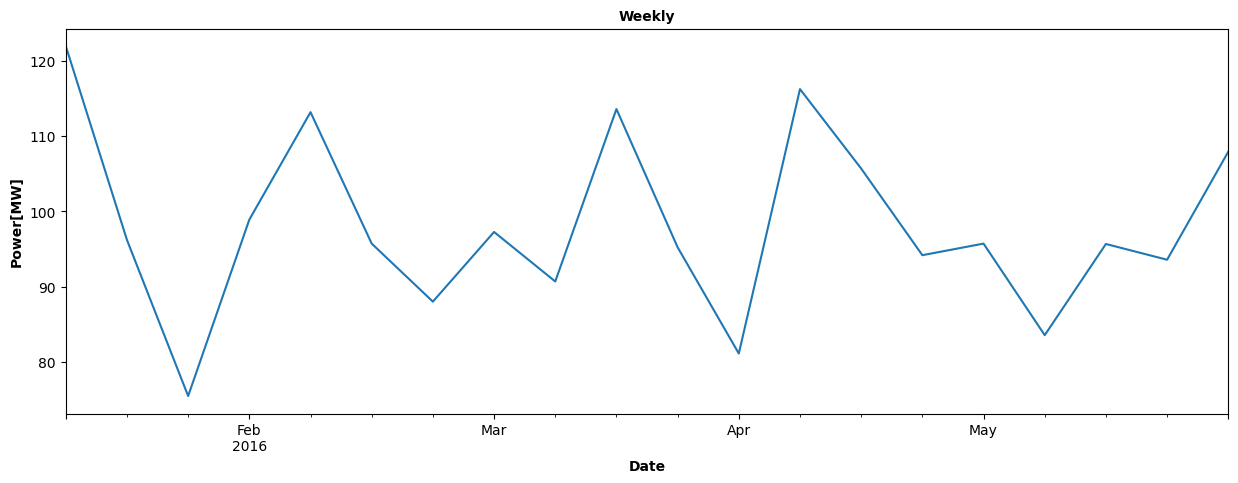

In [8]:
sample_type = 'Hourly'
df_monthly = SampledDataset(sample_type)

sample_type = 'Daily'
df_daily= SampledDataset(sample_type)

sample_type = 'Weekly'
df_weekly= SampledDataset(sample_type)

Next, I will use Augmented Dickey-Fuller (ADF) to test the smoothness of the time series data.

In [45]:
from statsmodels.tsa.stattools import adfuller

def adf(time_series):
    # Perform ADF unit root test
    dftest = adfuller(time_series, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],)
    
    # Add critical values to the result Series
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value

    print(dfoutput)

adf(df)


Test Statistic                   -21.616378
p-value                            0.000000
#Lags Used                        11.000000
Number of Observations Used    19723.000000
Critical Value (1%)               -3.430682
Critical Value (5%)               -2.861687
Critical Value (10%)              -2.566848
dtype: float64


It can be seen that the time series is stable as p-value < 0.05.

### 3. Pre-process the data

To split the dataset, I will split the dataset in a 6:2:2 ratio

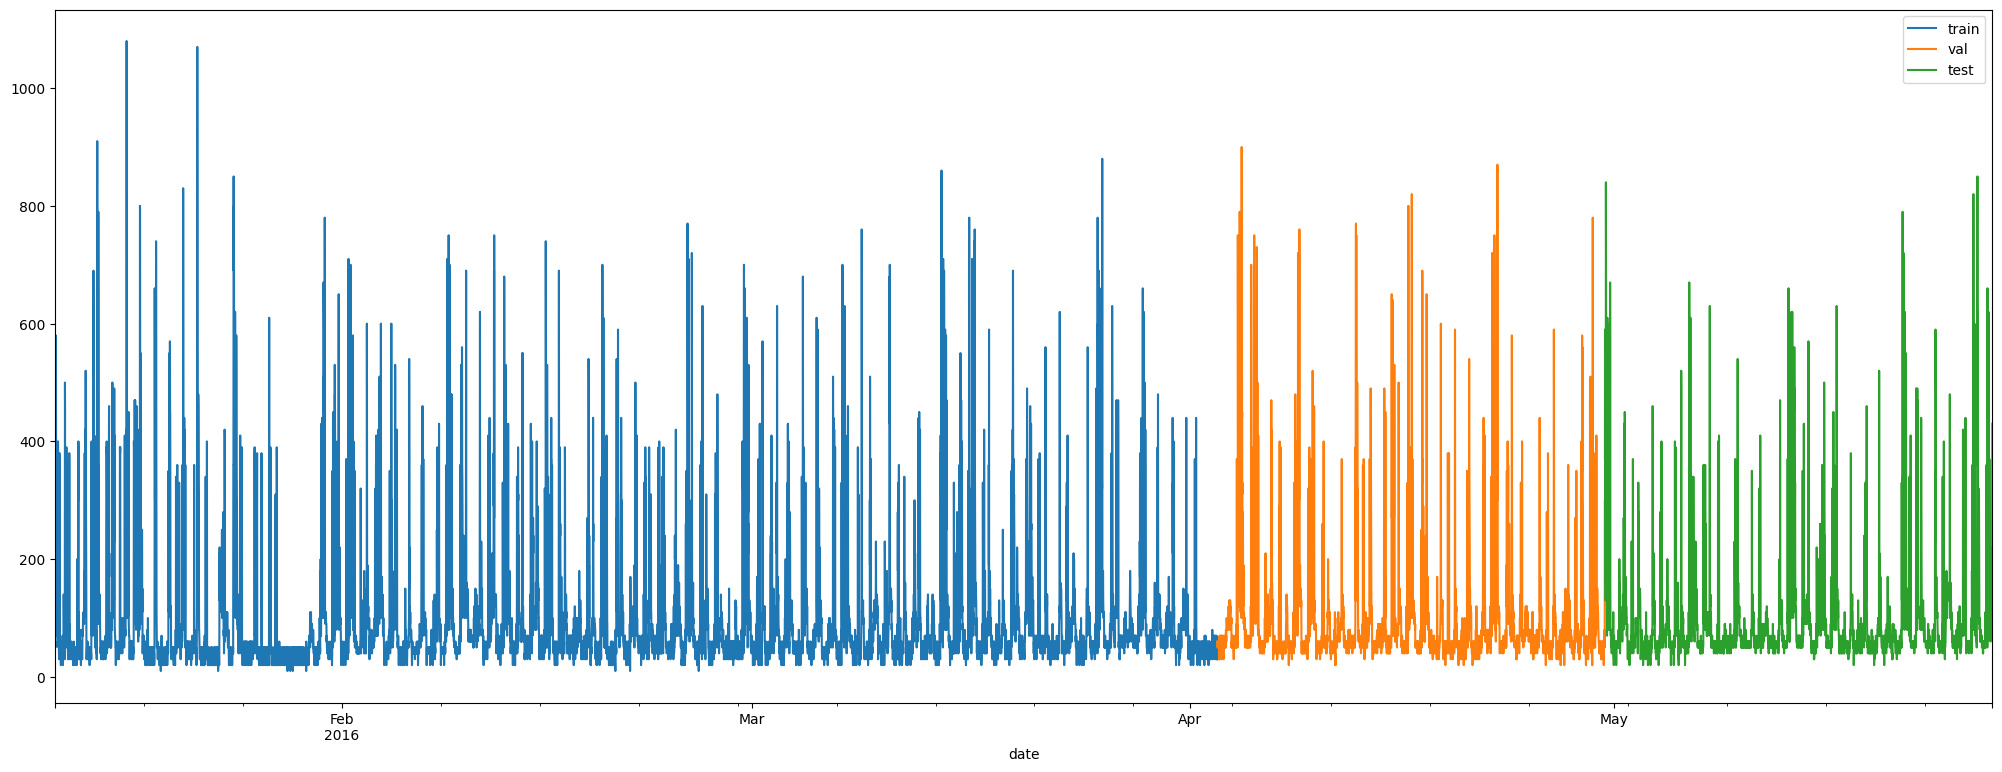

In [46]:
appliances=df[['Appliances']]

# Calculate the length of the dataset
total_length = len(appliances)
train_ratio = 0.6 
val_ratio = 0.2
test_ratio = 0.2

train_length = int(total_length * train_ratio)
val_length = int(total_length * val_ratio)
test_length = total_length - train_length - val_length

# split the dataset
train_data = pd.DataFrame(appliances.iloc[:train_length])
val_data = pd.DataFrame(appliances.iloc[train_length:train_length + val_length])
test_data = pd.DataFrame(appliances.iloc[train_length + val_length:])

fig = plt.figure(figsize=(26, 8))
ax = fig.add_subplot(111)
train_data.plot(ax=ax)
val_data.plot(ax=ax)
test_data.plot(ax=ax)
plt.legend(['train', 'val', 'test'])
plt.show()

### 4. Implement, train and test prediction models

#### （1）ARIMA model

By calling the auto_arima function, the system will automatically select the optimal ARIMA model parameters based on the characteristics of the training data

In [68]:
import pmdarima as pm

search_model = pm.arima.auto_arima(train_data['Appliances'],
                                   start_p=1, start_q=1, d=1,
                                   max_p=7, max_q=7, max_d=5,
                                   max_order=None,
                                   seasonal=False,
                                   test='adf',
                                   trace=True,
                                   error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=133938.869, Time=2.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=135466.082, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=135425.610, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=135389.518, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=135464.082, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=133721.126, Time=2.84 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=134854.043, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=133713.498, Time=5.94 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=134602.463, Time=0.62 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=133715.379, Time=14.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=133715.382, Time=11.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=133713.453, Time=5.88 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=133711.605, Time=3.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=134275.745, Time=1.90 sec
 AR

In [47]:
p= 7
q= 1
d= 3

In [48]:
from statsmodels.tsa.arima.model import ARIMA

# Creating ARIMA model objects and fitting the model
model = ARIMA(train_data, order=(p, d, q))
fitted_model = model.fit()

/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yuqing/Library/Python/3.9/lib/python/site-packages/stat

In [49]:
from sklearn.metrics import mean_squared_error

def evaluate(target, prediction): 
    
    target, prediction = np.array(target), np.array(prediction)
    mape = np.mean(np.abs((target - prediction) / target)) * 100

    print(f'mean Absolute Percentage Error: {mape:.2f}')

# Get the model's predictions on the validation dataset
predcited_set = fitted_model.apply(val_data['Appliances'])
prediction= predcited_set.fittedvalues

print('Mean Sqaured Error: {:.2f}'.format(mean_squared_error(val_data['Appliances'], prediction)))
evaluate(val_data['Appliances'],prediction)

Mean Sqaured Error: 5737.70
mean Absolute Percentage Error: 27.59


/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


In [50]:
y_test = test_data['Appliances']
forecasted_set = fitted_model.apply(test_data['Appliances'])
y_forecast= forecasted_set.fittedvalues

print(f'Mean Squared Error: {mean_squared_error(y_forecast,y_test):.2f}')
evaluate(y_test,y_forecast)

Mean Squared Error: 5120.40
mean Absolute Percentage Error: 26.86


/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


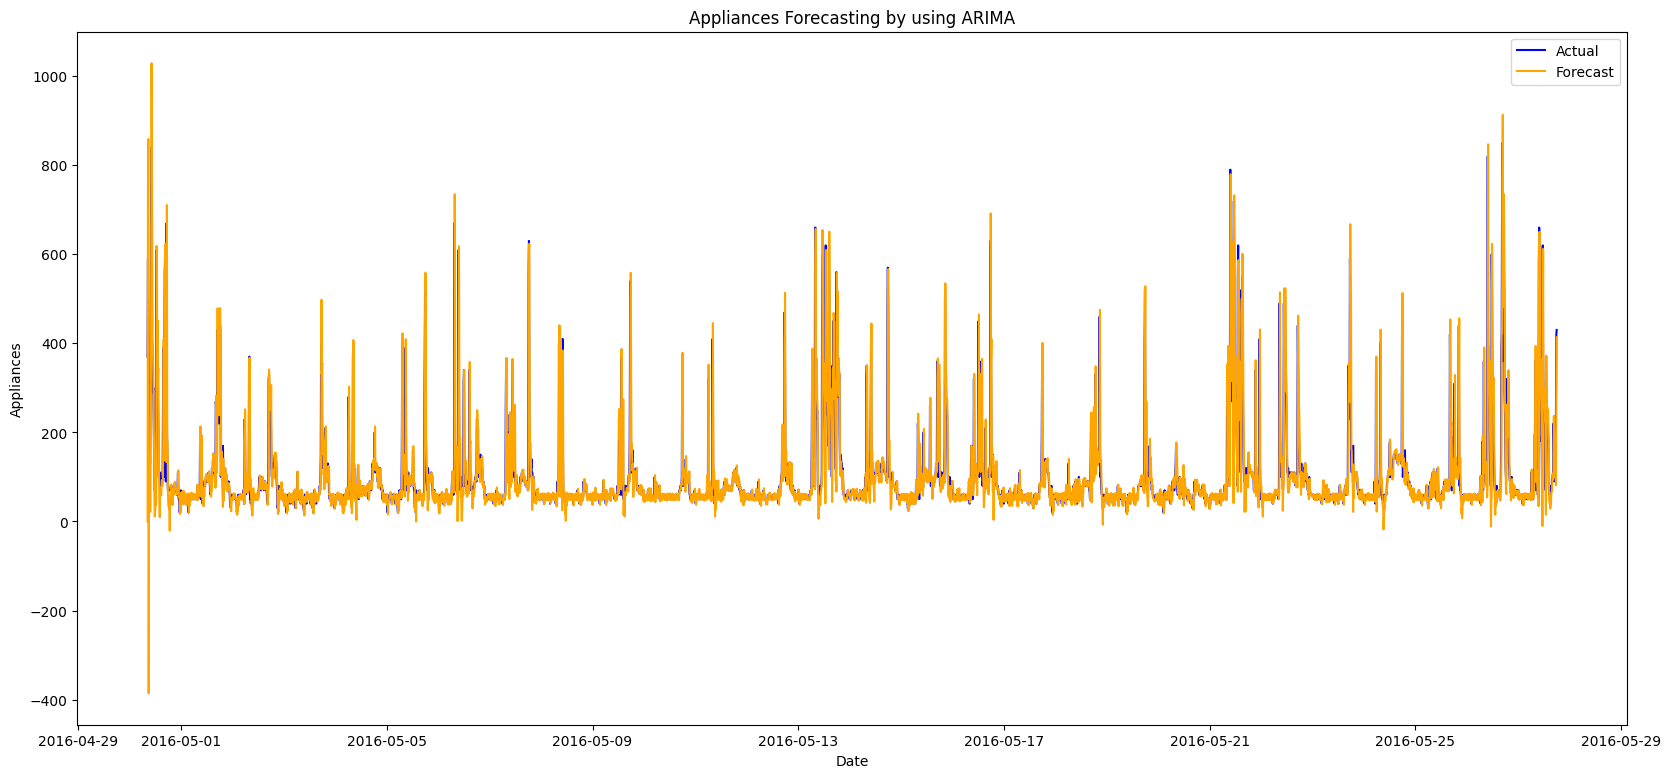

In [51]:
# Plotting predicted versus actual values
plt.figure(figsize=(20, 9))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_forecast, label='Forecast', color='orange')
plt.ylabel('Appliances')
plt.xlabel('Date')
plt.title('Appliances Forecasting by using ARIMA')
plt.legend()
arima_show = plt.show()

#### （1）LSTM model

##### Normalization of data - data pre process for the LSTM

In [53]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Normalization
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

# Normalized data converted to DataFrame format
train_scaled_df = pd.DataFrame(train_scaled, columns=['Scaled'], index=train_data.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=['Scaled'], index=val_data.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=['Scaled'], index=test_data.index)

##### Create lag features

In [54]:
for i in range(1, 19):
    train_scaled_df ['Scaled_{}'.format(i)]=train_scaled_df ['Scaled'].shift(i)
    val_scaled_df ['Scaled_{}'.format(i)]=val_scaled_df ['Scaled'].shift(i)
    test_scaled_df ['Scaled_{}'.format(i)]=test_scaled_df ['Scaled'].shift(i)

In [55]:
val_scaled_df

,Scaled,Scaled_1,Scaled_2,Scaled_3,Scaled_4,Scaled_5,Scaled_6,Scaled_7,Scaled_8,Scaled_9,Scaled_10,Scaled_11,Scaled_12,Scaled_13,Scaled_14,Scaled_15,Scaled_16,Scaled_17,Scaled_18
date,,,,,,,,,,,,,,,,,,,
2016-04-02 22:30:00,0.046729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-02 22:40:00,0.046729,0.046729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-02 22:50:00,0.046729,0.046729,0.046729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-02 23:00:00,0.037383,0.046729,0.046729,0.046729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-02 23:10:00,0.046729,0.037383,0.046729,0.046729,0.046729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-30 07:30:00,0.065421,0.046729,0.037383,0.037383,0.046729,0.028037,0.018692,0.009346,0.028037,0.037383,0.037383,0.046729,0.037383,0.046729,0.037383,0.046729,0.037383,0.037383,0.037383
2016-04-30 07:40:00,0.065421,0.065421,0.046729,0.037383,0.037383,0.046729,0.028037,0.018692,0.009346,0.028037,0.037383,0.037383,0.046729,0.037383,0.046729,0.037383,0.046729,0.037383,0.037383
2016-04-30 07:50:00,0.037383,0.065421,0.065421,0.046729,0.037383,0.037383,0.046729,0.028037,0.018692,0.009346,0.028037,0.037383,0.037383,0.046729,0.037383,0.046729,0.037383,0.046729,0.037383


Shown above, val_scaled_df, train_scaled_df, and test_scaled_df contain half of the missing values. So I am going to remove all the rows that contain missing values.

In [56]:
# Removes missing values from the dataset
x_train=train_scaled_df.dropna().drop('Scaled', axis=1)
y_train=train_scaled_df.dropna()[['Scaled']]

x_val=val_scaled_df.dropna().drop('Scaled', axis=1)
y_val=val_scaled_df.dropna()[['Scaled']]

x_test=test_scaled_df.dropna().drop('Scaled', axis=1)
y_test=test_scaled_df.dropna()[['Scaled']]

To facilitate subsequent processing, I converted the dataset to the NumPy array format

In [57]:
# Convert the training, validation, and test sets to NumPy arrays
x_train=x_train.to_numpy()
x_test=x_test.to_numpy()
x_val=x_val.to_numpy()
 
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()
y_val=y_val.to_numpy()
 
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(y_val.shape)
print(y_train.shape)
print(y_test.shape)

(11823, 18)
(3929, 18)
(3929, 18)
(3929, 1)
(11823, 1)
(3929, 1)


In [58]:
# Reshaping to match input requirements of LSTM models
x_train_t = x_train.reshape(x_train.shape[0], 18,1)
x_test_t = x_test.reshape(x_test.shape[0], 18, 1)
x_val_t = x_val.reshape(x_val.shape[0], 18, 1)

In [60]:
import tensorflow.keras.backend as K 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.layers import Dense 

# Clear any existing session to free up resources
K.clear_session() 
model = Sequential()
# Add the first LSTM layer with 30 units, returning full sequence, input shape is (18, 1)
model.add(LSTM(30, return_sequences=True, input_shape=(18, 1)))
# Add the second LSTM layer with 42 units, returning only the last output
model.add(LSTM(42, return_sequences=False))
# Add a fully connected layer with 1 neuron, using sigmoid activation to produce output
model.add(Dense(1, activation='sigmoid'))
# Compile the model using mean squared error loss and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')
# Print the summary of the model including parameter count for each layer and the overall structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 18, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 42)                12264     
                                                                 
 dense (Dense)               (None, 1)                 43        
                                                                 
Total params: 16147 (63.07 KB)
Trainable params: 16147 (63.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
from tensorflow.keras.callbacks import EarlyStopping
# validation 
early_stoper = EarlyStopping(monitor='loss', patience=5, verbose=1)
model.fit(x_train_t, y_train, epochs=35, batch_size=20, verbose=1, callbacks=[early_stoper])
y_pred_val = model.predict(x_val)

Epoch 1/35


592/592 [==============================] - 3s 4ms/step - loss: 0.0123
Epoch 2/35
592/592 [==============================] - 2s 4ms/step - loss: 0.0064
Epoch 3/35
592/592 [==============================] - 2s 4ms/step - loss: 0.0061
Epoch 4/35
592/592 [==============================] - 3s 4ms/step - loss: 0.0057
Epoch 5/35
592/592 [==============================] - 3s 4ms/step - loss: 0.0054
Epoch 6/35
592/592 [==============================] - 3s 4ms/step - loss: 0.0050
Epoch 7/35
592/592 [==============================] - 3s 4ms/step - loss: 0.0050
Epoch 8/35
592/592 [==============================] - 3s 4ms/step - loss: 0.0048
Epoch 9/35
592/592 [==============================] - 3s 4ms/step - loss: 0.0047
Epoch 10/35
592/592 [==============================] - 3s 4ms/step - loss: 0.0046
Epoch 11/35
592/592 [==============================] - 3s 4ms/step - loss: 0.0045
Epoch 12/35
592/592 [==============================] - 3s 4ms/step - loss: 0.0044
Epoch 13/35
592/592 [===============

In [62]:
from tensorflow.keras.callbacks import EarlyStopping
# testing
early_stoping = EarlyStopping(monitor='loss', patience=4, verbose=1)
model.fit(x_train_t, y_train, epochs=28, batch_size=20, verbose=1, callbacks=[early_stoping])
y_pred = model.predict(x_test_t)

Epoch 1/28
592/592 [==============================] - 3s 4ms/step - loss: 0.0121
Epoch 2/28
592/592 [==============================] - 2s 4ms/step - loss: 0.0063
Epoch 3/28
592/592 [==============================] - 2s 4ms/step - loss: 0.0057
Epoch 4/28
592/592 [==============================] - 2s 4ms/step - loss: 0.0053
Epoch 5/28
592/592 [==============================] - 2s 4ms/step - loss: 0.0050
Epoch 6/28
592/592 [==============================] - 2s 4ms/step - loss: 0.0049
Epoch 7/28
592/592 [==============================] - 2s 4ms/step - loss: 0.0047
Epoch 8/28
592/592 [==============================] - 2s 4ms/step - loss: 0.0047
Epoch 9/28
592/592 [==============================] - 2s 4ms/step - loss: 0.0046
Epoch 10/28
592/592 [==============================] - 2s 4ms/step - loss: 0.0046
Epoch 11/28
592/592 [==============================] - 2s 4ms/step - loss: 0.0046
Epoch 12/28
592/592 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 13/28
592/592 [====

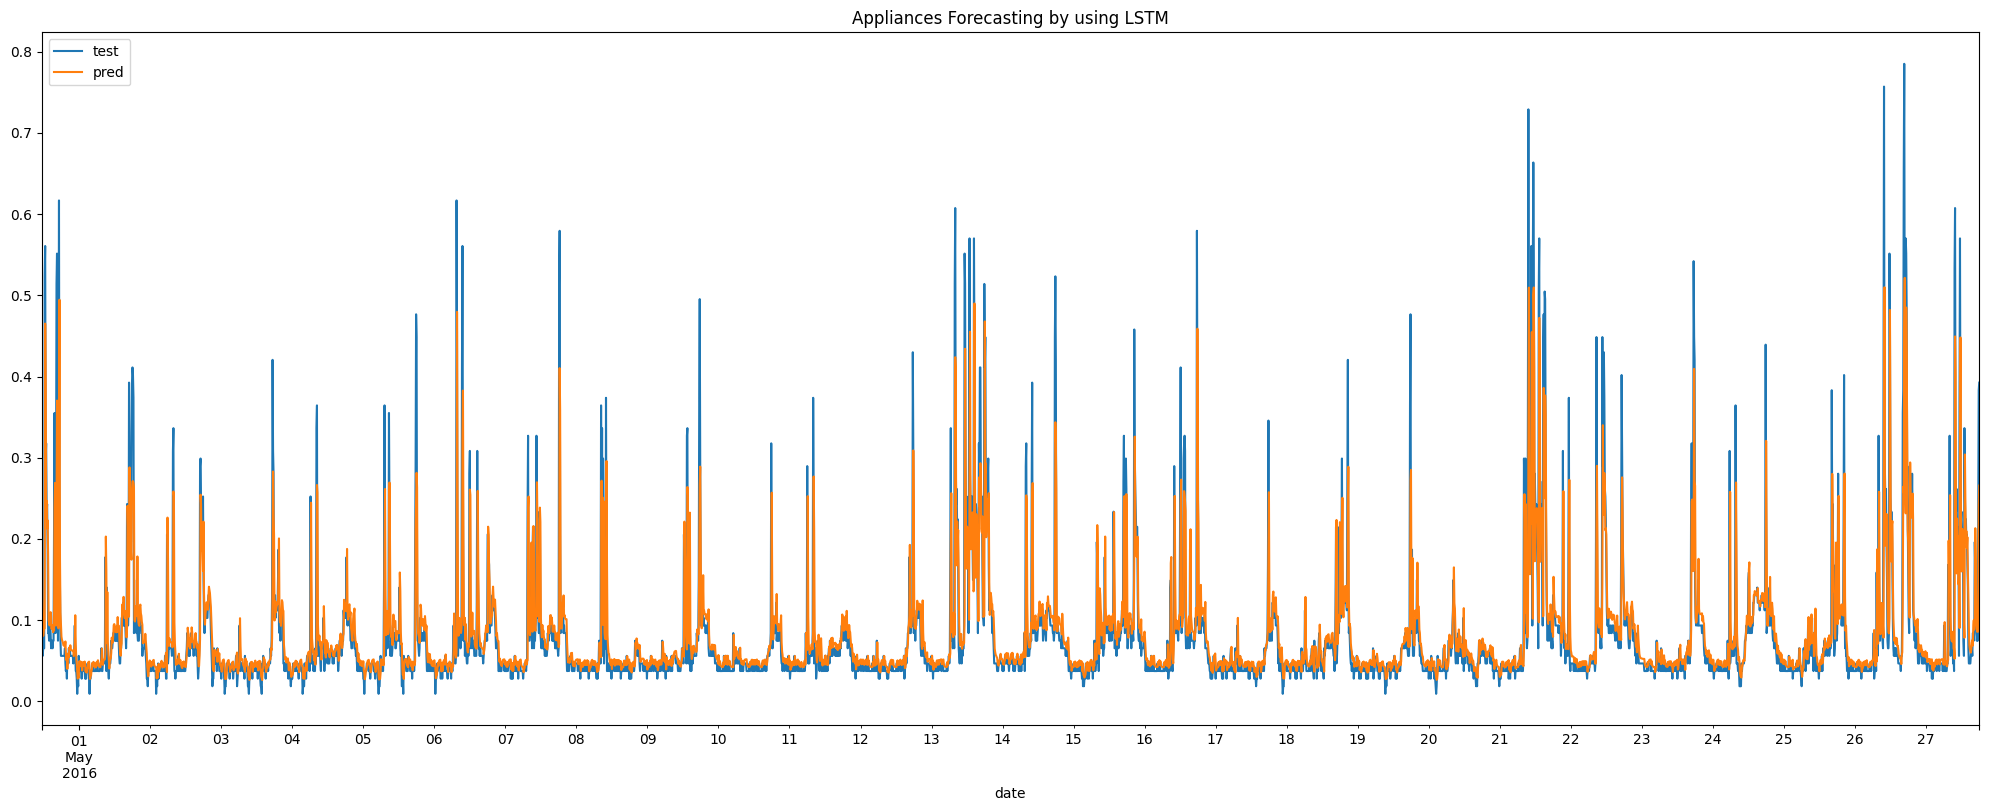

In [63]:
t_df=test_scaled_df.dropna()
y_test_df=pd.DataFrame(y_test, columns=['Appliances'], index=t_df.index)
y_pred_df=pd.DataFrame(y_pred, columns=['Appliances'], index=t_df.index)
 
 
fig = plt.figure(figsize=(25, 9))
ax1 = fig.add_subplot(111)
y_test_df.plot(ax=ax1)
y_pred_df.plot(ax=ax1)
plt.title('Appliances Forecasting by using LSTM')
plt.legend(['test','pred'])

### 5. Compare the results from all candidate models, choose the best model, justify your choice and discuss the results


Compare with the results you have obtained in Assignment 1a.

The results predicted by the two models are shown below

![Alt text](image-1.png)

![Alt text](image.png)

### 6. Reflect on what you have learned by completing this assignment and how to improve the models

### 7. References